<a href="https://colab.research.google.com/github/yassienshaalan/applied-ml-ai-systems-articles/blob/main/Uncertainty_in_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install xgboost==2.0.3 scikit-learn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 5.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone

from xgboost import XGBClassifier

# -----------------------
# Global config
# -----------------------
SEEDS = [7, 13, 21, 42, 99]
N_BINS = 10
TOP_FRAC = 0.10

# -----------------------
# Helper functions
# -----------------------
def predictive_entropy(p, eps=1e-12):
    p = np.clip(np.asarray(p), eps, 1 - eps)
    return -(p * np.log(p) + (1 - p) * np.log(1 - p))

def confidence_from_proba(p):
    p = np.asarray(p)
    return np.maximum(p, 1 - p)

def ece(y_true, p, n_bins=10):
    y_true = np.asarray(y_true)
    p = np.asarray(p)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    e = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (p >= lo) & (p < hi) if i < n_bins - 1 else (p >= lo) & (p <= hi)
        if mask.sum() == 0:
            continue
        acc = y_true[mask].mean()
        conf = p[mask].mean()
        e += (mask.sum() / len(p)) * abs(acc - conf)
    return float(e)

def metrics_row(y_true, p):
    y_true = np.asarray(y_true)
    p = np.asarray(p)

    auc = roc_auc_score(y_true, p)
    auprc = average_precision_score(y_true, p)
    brier = brier_score_loss(y_true, p)
    ent = predictive_entropy(p).mean()
    cal = ece(y_true, p, n_bins=N_BINS)

    conf = confidence_from_proba(p)
    k = max(1, int(len(conf) * TOP_FRAC))
    top_idx = np.argsort(-conf)[:k]
    y_hat = (p >= 0.5).astype(int)
    top_err = (y_hat[top_idx] != y_true[top_idx]).mean()

    return {
        "auroc": float(auc),
        "auprc": float(auprc),
        "brier": float(brier),
        "mean_entropy": float(ent),
        "ece": float(cal),
        "top_conf_error_rate": float(top_err),
        "top_conf_threshold": float(conf[top_idx].min()),
    }

def bin_table(y_true, p, n_bins=10):
    y_true = np.asarray(y_true)
    p = np.asarray(p)
    conf = confidence_from_proba(p)

    edges = np.linspace(0.5, 1.0, n_bins + 1)
    rows = []
    for b in range(n_bins):
        lo, hi = edges[b], edges[b+1]
        mask = (conf >= lo) & (conf < hi) if b < n_bins - 1 else (conf >= lo) & (conf <= hi)
        if mask.sum() == 0:
            continue
        y_hat = (p[mask] >= 0.5).astype(int)
        err = (y_hat != y_true[mask]).mean()
        rows.append({
            "conf_bin": b,
            "conf_lo": lo,
            "conf_hi": hi,
            "count": int(mask.sum()),
            "error_rate": float(err),
            "mean_conf": float(conf[mask].mean()),
            "mean_entropy": float(predictive_entropy(p[mask]).mean())
        })
    return pd.DataFrame(rows)

def make_models(seed):
    # A simple model vs a high-capacity "compression" model
    logreg = LogisticRegression(max_iter=2000, solver="lbfgs")

    xgb_big = XGBClassifier(
        n_estimators=1200, max_depth=8, learning_rate=0.05,
        subsample=1.0, colsample_bytree=1.0,
        reg_lambda=0.5, gamma=0.0,
        random_state=seed, tree_method="hist",
        eval_metric="logloss"
    )
    return {"logreg": logreg, "xgb_big": xgb_big}

In [ ]:
# Experiment 1: I want to build an "ambiguous" dataset (overlap + boundary noise)
# Goal: show uncertainty can be compressed into confidence while errors concentrate in high-confidence regions.

def make_ambiguous_dataset(seed, n=40000):
    rng = np.random.default_rng(seed)
    X, y = make_classification(
        n_samples=n,
        n_features=25,
        n_informative=8,
        n_redundant=5,
        n_clusters_per_class=2,
        class_sep=0.7,          # overlap
        flip_y=0.02,            # base noise
        weights=[0.65, 0.35],
        random_state=seed
    )

    # Add *boundary* label noise: flip labels for points near the decision boundary proxy
    # Proxy = distance from a random projection (simple, reproducible)
    w = rng.normal(size=X.shape[1])
    score = X @ w
    # near boundary = within quantile band around median
    med = np.median(score)
    band = np.quantile(np.abs(score - med), 0.20)  # 20% closest to boundary
    boundary = np.abs(score - med) <= band

    flip_prob = 0.20
    flips = (rng.random(size=len(y)) < flip_prob) & boundary
    y2 = y.copy()
    y2[flips] = 1 - y2[flips]
    return X, y2

metric_rows = []
bin_rows = []

for seed in SEEDS:
    X, y = make_ambiguous_dataset(seed)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=seed, stratify=y
    )

    models = make_models(seed)

    for name, model in models.items():
        mdl = clone(model)
        mdl.fit(X_train, y_train)

        p = mdl.predict_proba(X_test)[:, 1]
        m = metrics_row(y_test, p)

        metric_rows.append({
            "seed": seed,
            "experiment": "EXP1_COMPRESSION",
            "model": name,
            **m
        })

        bdf = bin_table(y_test, p, n_bins=N_BINS)
        bdf["seed"] = seed
        bdf["experiment"] = "EXP1_COMPRESSION"
        bdf["model"] = name
        bin_rows.append(bdf)

metrics_df = pd.DataFrame(metric_rows)
bins_df = pd.concat(bin_rows, ignore_index=True)

metrics_df.to_csv("exp1_compression_metrics.csv", index=False)
bins_df.to_csv("exp1_compression_bins.csv", index=False)

print("Saved exp1_compression_metrics.csv rows:", len(metrics_df))
print("Saved exp1_compression_bins.csv rows:", len(bins_df))

summary = (metrics_df
           .groupby(["model"])
           .agg(auroc_mean=("auroc","mean"),
                auprc_mean=("auprc","mean"),
                brier_mean=("brier","mean"),
                entropy_mean=("mean_entropy","mean"),
                ece_mean=("ece","mean"),
                top_err_mean=("top_conf_error_rate","mean"))
           .reset_index())

display(summary.sort_values("auprc_mean", ascending=False))


Saved exp1_compression_metrics.csv rows: 10
Saved exp1_compression_bins.csv rows: 100


,model,auroc_mean,auprc_mean,brier_mean,entropy_mean,ece_mean,top_err_mean
1,xgb_big,0.938943,0.908283,0.082923,0.161172,0.041442,0.0194
0,logreg,0.749952,0.631833,0.188575,0.559628,0.031912,0.1228


In [ ]:
# Experiment 2: Allocation (Uncertainty Budget via Abstention)
# Robust calibration: Platt scaling (LR on logits) - avoids CalibratedClassifierCV tag issues.

from sklearn.linear_model import LogisticRegression

COST_FP = 5.0
COST_FN = 10.0
COST_ABSTAIN = 1.0

def expected_cost_curve(y_true, p, abstain_thresholds):
    """
    abstain if confidence < t
    else decide by p>=0.5
    """
    y_true = np.asarray(y_true)
    p = np.asarray(p)
    conf = confidence_from_proba(p)

    rows = []
    for t in abstain_thresholds:
        abstain = conf < t
        decided = ~abstain

        y_hat = (p >= 0.5).astype(int)

        fp = ((y_hat == 1) & (y_true == 0) & decided).sum()
        fn = ((y_hat == 0) & (y_true == 1) & decided).sum()

        cost = fp * COST_FP + fn * COST_FN + abstain.sum() * COST_ABSTAIN
        cost = cost / len(y_true)

        if decided.sum() > 0:
            err = (y_hat[decided] != y_true[decided]).mean()
        else:
            err = np.nan

        rows.append({
            "threshold": float(t),
            "coverage": float(decided.mean()),
            "abstain_rate": float(abstain.mean()),
            "accepted_error_rate": float(err) if not np.isnan(err) else np.nan,
            "expected_cost": float(cost),
            "fp_count": int(fp),
            "fn_count": int(fn),
        })
    return pd.DataFrame(rows)

def make_budget_dataset(seed, n=60000):
    X, y = make_classification(
        n_samples=n,
        n_features=30,
        n_informative=10,
        n_redundant=6,
        n_clusters_per_class=2,
        class_sep=1.0,
        flip_y=0.03,
        weights=[0.7, 0.3],
        random_state=seed
    )
    return X, y

def platt_calibrate(proba_uncal, y_cal):
    """
    Fit Platt scaling: LR on logits -> calibrated probabilities.
    Input: proba_uncal in (0,1), y_cal in {0,1}
    Returns a fitted calibrator function f(p)->p_cal
    """
    p = np.asarray(proba_uncal)
    y = np.asarray(y_cal)

    eps = 1e-12
    p = np.clip(p, eps, 1 - eps)
    logit = np.log(p / (1 - p)).reshape(-1, 1)

    lr = LogisticRegression(solver="lbfgs")
    lr.fit(logit, y)

    def calibrator(p_new):
        p_new = np.asarray(p_new)
        p_new = np.clip(p_new, eps, 1 - eps)
        logit_new = np.log(p_new / (1 - p_new)).reshape(-1, 1)
        return lr.predict_proba(logit_new)[:, 1]

    return calibrator

curve_rows = []
abstain_thresholds = np.linspace(0.50, 0.99, 40)

for seed in SEEDS:
    X, y = make_budget_dataset(seed)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=seed, stratify=y
    )

    # Split train into train + calibration
    X_tr, X_cal, y_tr, y_cal = train_test_split(
        X_train, y_train, test_size=0.25, random_state=seed, stratify=y_train
    )

    xgb = XGBClassifier(
        n_estimators=600, max_depth=5, learning_rate=0.06,
        subsample=0.9, colsample_bytree=0.9,
        reg_lambda=1.0, random_state=seed,
        tree_method="hist", eval_metric="logloss"
    )
    logreg = LogisticRegression(max_iter=2000, solver="lbfgs")

    # Fit models
    xgb.fit(X_tr, y_tr)
    logreg.fit(X_train, y_train)

    # Uncalibrated test probs
    p_xgb_test = xgb.predict_proba(X_test)[:, 1]

    # Fit Platt calibrator on calibration split
    p_xgb_cal = xgb.predict_proba(X_cal)[:, 1]
    calibrator = platt_calibrate(p_xgb_cal, y_cal)

    # Calibrated test probs
    p_xgb_test_cal = calibrator(p_xgb_test)

    # LogReg probs
    p_log_test = logreg.predict_proba(X_test)[:, 1]

    for model_name, p in [("xgb", p_xgb_test), ("xgb_platt", p_xgb_test_cal), ("logreg", p_log_test)]:
        cdf = expected_cost_curve(y_test, p, abstain_thresholds)
        cdf["seed"] = seed
        cdf["experiment"] = "EXP2_ALLOCATION_BUDGET"
        cdf["model"] = model_name

        base_m = metrics_row(y_test, p)
        for k, v in base_m.items():
            cdf[k] = v

        curve_rows.append(cdf)

curves_df = pd.concat(curve_rows, ignore_index=True)
curves_df.to_csv("exp2_allocation_budget_curve.csv", index=False)

print("Saved exp2_allocation_budget_curve.csv rows:", len(curves_df))

best = (curves_df
        .groupby(["model","threshold"])
        .agg(expected_cost_mean=("expected_cost","mean"),
             coverage_mean=("coverage","mean"),
             accepted_err_mean=("accepted_error_rate","mean"))
        .reset_index())

best_per_model = best.loc[best.groupby("model")["expected_cost_mean"].idxmin()].sort_values("expected_cost_mean")
display(best_per_model)


Saved exp2_allocation_budget_curve.csv rows: 600


,model,threshold,expected_cost_mean,coverage_mean,accepted_err_mean
105,xgb_platt,0.814103,0.256307,0.924293,0.022712
66,xgb,0.826667,0.262040,0.913960,0.022061
29,logreg,0.864359,0.736693,0.516507,0.058330


In [ ]:
# Experiment 3: Temporal deferral.
# I simulate time windows with distribution shift.
# I train an anchor at T0 and successive models at T1/T2, then evaluate on future T3.
# I measure confidence inflation, disagreement, and future performance.

def make_time_shifted_data(seed, n_per_window=20000, n_features=25):
    rng = np.random.default_rng(seed)

    def window_data(t):
        # Base classification data
        X, y = make_classification(
            n_samples=n_per_window,
            n_features=n_features,
            n_informative=8,
            n_redundant=5,
            n_clusters_per_class=2,
            class_sep=1.0,
            flip_y=0.02,
            weights=[0.65, 0.35],
            random_state=seed + t*101
        )
        # Apply time-dependent feature shift (mean shift + cov tilt)
        shift = (t * 0.40)  # progressively stronger
        X = X + shift

        # Add a "policy-like" drift: flip a small fraction of labels in later windows
        if t >= 2:
            flip_frac = 0.05 * (t - 1)
            idx = rng.choice(np.arange(len(y)), size=int(flip_frac * len(y)), replace=False)
            y[idx] = 1 - y[idx]
        return X, y

    data = {}
    for t in [0, 1, 2, 3]:
        data[t] = window_data(t)
    return data

def disagreement(p_a, p_b):
    # disagreement in predicted class
    ya = (p_a >= 0.5).astype(int)
    yb = (p_b >= 0.5).astype(int)
    return float((ya != yb).mean())

rows = []

for seed in SEEDS:
    data = make_time_shifted_data(seed)

    # Models (keep consistent family)
    def make_model(rs):
        return XGBClassifier(
            n_estimators=700, max_depth=5, learning_rate=0.06,
            subsample=0.9, colsample_bytree=0.9,
            reg_lambda=1.0, random_state=rs,
            tree_method="hist", eval_metric="logloss"
        )

    # Train anchor on T0
    X0, y0 = data[0]
    anchor = make_model(seed).fit(X0, y0)

    # Train successive models on T1 and T2
    X1, y1 = data[1]
    m1 = make_model(seed + 1).fit(X1, y1)

    X2, y2 = data[2]
    m2 = make_model(seed + 2).fit(X2, y2)

    # Evaluate on future window T3
    X3, y3 = data[3]
    p_anchor = anchor.predict_proba(X3)[:, 1]
    p1 = m1.predict_proba(X3)[:, 1]
    p2 = m2.predict_proba(X3)[:, 1]

    # Record metrics + disagreement + confidence dynamics
    for ver, p in [("anchor_T0", p_anchor), ("model_T1", p1), ("model_T2", p2)]:
        m = metrics_row(y3, p)
        rows.append({
            "seed": seed,
            "experiment": "EXP3_DEFERRAL_TIME",
            "version": ver,
            **m,
            "mean_confidence": float(confidence_from_proba(p).mean()),
        })

    # Pairwise disagreements on the same future data
    rows.append({
        "seed": seed,
        "experiment": "EXP3_DEFERRAL_TIME",
        "version": "disagreement_T0_vs_T1",
        "disagreement": disagreement(p_anchor, p1),
    })
    rows.append({
        "seed": seed,
        "experiment": "EXP3_DEFERRAL_TIME",
        "version": "disagreement_T0_vs_T2",
        "disagreement": disagreement(p_anchor, p2),
    })
    rows.append({
        "seed": seed,
        "experiment": "EXP3_DEFERRAL_TIME",
        "version": "disagreement_T1_vs_T2",
        "disagreement": disagreement(p1, p2),
    })

exp3_df = pd.DataFrame(rows)
exp3_df.to_csv("exp3_deferral_time.csv", index=False)

print("Saved exp3_deferral_time.csv rows:", len(exp3_df))

# Quick summary: average future performance + confidence by version
perf = exp3_df[exp3_df["version"].isin(["anchor_T0","model_T1","model_T2"])].copy()
summary = (perf
           .groupby("version")
           .agg(auroc_mean=("auroc","mean"),
                auprc_mean=("auprc","mean"),
                brier_mean=("brier","mean"),
                ece_mean=("ece","mean"),
                conf_mean=("mean_confidence","mean"),
                top_err_mean=("top_conf_error_rate","mean"))
           .reset_index())
display(summary)

# And average disagreement
dis = exp3_df[exp3_df["version"].str.startswith("disagreement")].copy()
if len(dis) > 0:
    dis_summary = dis.groupby("version").agg(disagree_mean=("disagreement","mean")).reset_index()
    display(dis_summary)


Saved exp3_deferral_time.csv rows: 30


,version,auroc_mean,auprc_mean,brier_mean,ece_mean,conf_mean,top_err_mean
0,anchor_T0,0.536023,0.427856,0.396803,0.365501,0.853028,0.4577
1,model_T1,0.526303,0.429181,0.355224,0.311174,0.837681,0.4551
2,model_T2,0.517224,0.403533,0.341123,0.278487,0.784423,0.4638


,version,disagree_mean
0,disagreement_T0_vs_T1,0.49351
1,disagreement_T0_vs_T2,0.49597
2,disagreement_T1_vs_T2,0.49206


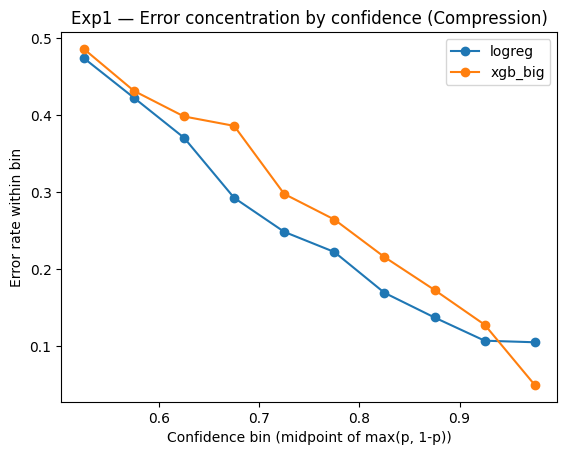

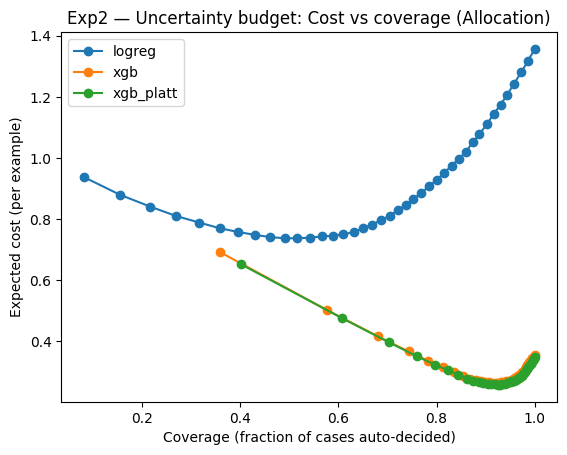

,model,threshold,expected_cost,coverage,accepted_error
105,xgb_platt,0.814103,0.256307,0.924293,0.022712
66,xgb,0.826667,0.262040,0.913960,0.022061
29,logreg,0.864359,0.736693,0.516507,0.058330


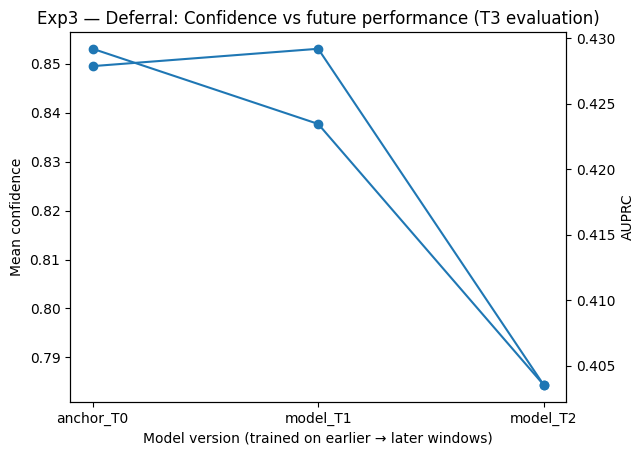

,version,disagree_mean
1,disagreement_T0_vs_T2,0.49597
0,disagreement_T0_vs_T1,0.49351
2,disagreement_T1_vs_T2,0.49206


from matplotlib import pyplot as plt
_df_0['disagree_mean'].plot(kind='hist', bins=20, title='disagree_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('version').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['disagree_mean'].plot(kind='line', figsize=(8, 4), title='disagree_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['version'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='disagree_mean', y='version', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Plotting cell (reads the CSVs produced by Exp1–Exp3 and generates the 3 key figures)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Load outputs
# -----------------------
exp1_bins = pd.read_csv("exp1_compression_bins.csv")
exp1_metrics = pd.read_csv("exp1_compression_metrics.csv")

exp2_curve = pd.read_csv("exp2_allocation_budget_curve.csv")

exp3 = pd.read_csv("exp3_deferral_time.csv")

# -----------------------
# Figure 1: Error concentration by confidence (Exp1)
# -----------------------
# Average bins across seeds
b1 = (exp1_bins
      .groupby(["model","conf_bin","conf_lo","conf_hi"])
      .agg(error_rate=("error_rate","mean"),
           mean_conf=("mean_conf","mean"),
           mean_entropy=("mean_entropy","mean"),
           count=("count","sum"))
      .reset_index()
      .sort_values(["model","conf_bin"]))

plt.figure()
for model in b1["model"].unique():
    sub = b1[b1["model"] == model].sort_values("conf_bin")
    # X-axis as bin midpoint for readability
    x = (sub["conf_lo"].values + sub["conf_hi"].values) / 2.0
    plt.plot(x, sub["error_rate"].values, marker="o", label=model)

plt.xlabel("Confidence bin (midpoint of max(p, 1-p))")
plt.ylabel("Error rate within bin")
plt.title("Exp1 — Error concentration by confidence (Compression)")
plt.legend()
plt.show()

# -----------------------
# Figure 2: Cost vs coverage (Exp2)
# -----------------------
# Average curves across seeds
b2 = (exp2_curve
      .groupby(["model","threshold"])
      .agg(expected_cost=("expected_cost","mean"),
           coverage=("coverage","mean"),
           accepted_error=("accepted_error_rate","mean"))
      .reset_index()
      .sort_values(["model","threshold"]))

plt.figure()
for model in b2["model"].unique():
    sub = b2[b2["model"] == model].sort_values("coverage")
    plt.plot(sub["coverage"].values, sub["expected_cost"].values, marker="o", label=model)

plt.xlabel("Coverage (fraction of cases auto-decided)")
plt.ylabel("Expected cost (per example)")
plt.title("Exp2 — Uncertainty budget: Cost vs coverage (Allocation)")
plt.legend()
plt.show()

# Optional: show best operating point per model (min expected cost)
best_pts = b2.loc[b2.groupby("model")["expected_cost"].idxmin()].copy()
display(best_pts.sort_values("expected_cost"))

# -----------------------
# Figure 3: Confidence + AUPRC across time versions (Exp3)
# -----------------------
perf = exp3[exp3["version"].isin(["anchor_T0","model_T1","model_T2"])].copy()

b3 = (perf
      .groupby("version")
      .agg(auprc=("auprc","mean"),
           auroc=("auroc","mean"),
           brier=("brier","mean"),
           ece=("ece","mean"),
           mean_confidence=("mean_confidence","mean"),
           top_conf_error=("top_conf_error_rate","mean"))
      .reset_index())

# Plot mean confidence (left axis) and AUPRC (right axis) on the same figure
order = ["anchor_T0","model_T1","model_T2"]
b3["version"] = pd.Categorical(b3["version"], categories=order, ordered=True)
b3 = b3.sort_values("version")

x = np.arange(len(b3))

fig, ax1 = plt.subplots()
ax1.plot(x, b3["mean_confidence"].values, marker="o", label="Mean confidence")
ax1.set_xlabel("Model version (trained on earlier → later windows)")
ax1.set_ylabel("Mean confidence")

ax2 = ax1.twinx()
ax2.plot(x, b3["auprc"].values, marker="o", label="AUPRC")
ax2.set_ylabel("AUPRC")

ax1.set_xticks(x)
ax1.set_xticklabels([str(v) for v in b3["version"].values])
plt.title("Exp3 — Deferral: Confidence vs future performance (T3 evaluation)")
plt.show()

# Disagreement table (not a plot, but a key datapoint for narrative)
dis = exp3[exp3["version"].str.startswith("disagreement")].copy()
if len(dis) > 0:
    dis_summary = dis.groupby("version").agg(disagree_mean=("disagreement","mean")).reset_index()
    display(dis_summary.sort_values("disagree_mean", ascending=False))
